Using GPU as it provides speedup


In [1]:
#Using GPU as it provides speedup
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## MOUNT DRIVE

Mount drive so we can retrieve the data

In [32]:
#Mount drive
from google.colab import drive
#This will prompt for authorization 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
# See drive content
!ls '/content/drive/My Drive/MLContests/AILaunchLab/data'

 Challenge_sea_ice_guidelines.pdf   DRIFT_DATA_TRAIN.csv
 DRIFT_DATA_TEST.csv		   'Samples DRIFT_DATA_TRAIN.csv'


## LOAD THE DATA


In [149]:
#Load packages
import numpy as np
import pandas as pd

class Dataset:
    """Class for loading the dataset"""
    def __init__(self):
        self._currPath = '/content/drive/My Drive/MLContests/AILaunchLab' #root path of the full the project

    def LoadDataframe(self):
      """Load the data"""
      df1 = pd.read_csv(self._currPath+"/data/DRIFT_DATA_TRAIN.csv") #our training/validation set
      df2 = pd.read_csv(self._currPath+"/data/DRIFT_DATA_TEST.csv") #contest test set
      print("dataframe: \n", df1.head())
      self._df1 = df1
      self._df2 = df2
    
    def LoadX(self):
        """Select the inputs"""
        #We did not select h_CS2SMOS as it was not continious data so we eliminated it
        #id_buoy: ​numerical buoy identifier not selected because
 # 'year', 'month','day','doy'
        #print("Columns: ", self._df1.columns)
        X = self._df1[['x_EASE','y_EASE','u_ERA5','v_ERA5','sic_CDR', 'h_cs2smos', 'h_piomas', 'd2c']]
        X = X.fillna(0)
        print("X: \n", X.head())
        self._X = X
        
    def LoadY(self):
        """Load the outputs"""
        Y = self._df1[['u_buoy','v_buoy']]
        print("Y: \n", Y.head())
        self._Y = Y
    
    def LoadXtest(self):
        """Select the inputs"""
        #We did not select h_CS2SMOS as it was not continious data so we eliminated it
        #id_buoy: ​numerical buoy identifier not selected because
        # 'year', 'month','day','doy'
        #print("Columns: ", self._df1.columns)
        X_test = self._df2[['x_EASE','y_EASE','u_ERA5','v_ERA5','sic_CDR', 'h_cs2smos', 'h_piomas', 'd2c']]
        X_test = X_test.fillna(0)
        print("X_test: \n", X_test.head())
        self._X_test = X_test
        
      
    def GetX(self):
        """Get the list of inputs"""
        return self._X

    def GetXTest(self):
      """Get the list of inputs"""
      return self._X_test
    
    def GetY(self):
        """Get the array of inputs"""
        return self._Y

In [135]:
#Call methods to load the data
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

dataset = Dataset()
dataset.LoadDataframe()
dataset.LoadX()
dataset.LoadY()
dataset.LoadXtest()

dataframe: 
    year  month  day  doy  ...   sic_CDR  h_cs2smos  h_piomas         d2c
0  1979      2   18   49  ...  0.990195        0.0  3.189743  522.523298
1  1979      2   18   49  ...  0.966372        0.0  2.484009  412.767669
2  1979      2   18   49  ...  0.996022        0.0  2.474106  362.547379
3  1979      2   18   49  ...  0.982681        0.0  3.740522  381.025629
4  1979      2   19   50  ...  0.990302        0.0  3.188522  521.535334

[5 rows x 15 columns]
X: 
        x_EASE      y_EASE    u_ERA5  ...  h_cs2smos  h_piomas         d2c
0  147.506958  138.582672 -6.704156  ...        0.0  3.189743  522.523298
1  146.834778  120.509880 -6.818630  ...        0.0  2.484009  412.767669
2  130.993561  129.623672 -8.825469  ...        0.0  2.474106  362.547379
3  147.524719  157.382492 -1.079951  ...        0.0  3.740522  381.025629
4  147.470963  138.599823 -2.169171  ...        0.0  3.188522  521.535334

[5 rows x 8 columns]
Y: 
      u_buoy    v_buoy
0 -0.797554  1.114740
1  0.6

## Data visualisation

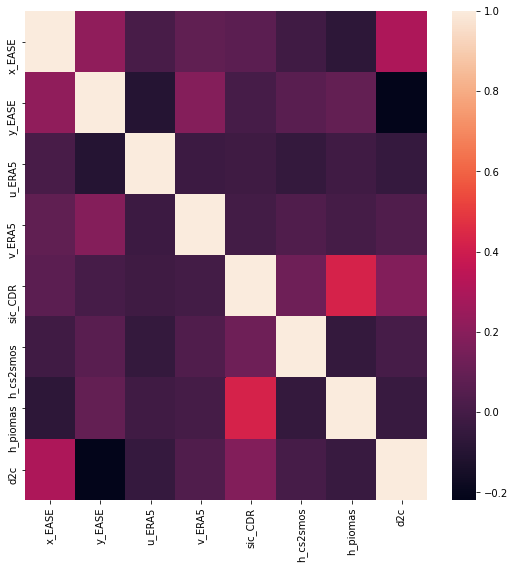

In [114]:
#Plot the heatmap, see the correlation between the data
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#Data Visualization of DRIFT DATA TRAIN
#Building the Correlation matrix
f, ax = plt.subplots(1, figsize=(9, 9))
sns.heatmap(dataset.GetX().corr())

Feature normalization: algorithms perform better when numerical input variables are scaled to a standard range

Shuffle the data

In [120]:
#SHUFFLE the data before cross-validating
#We will perform cross-validation so we don't need to split the data
X = np.array(X_scaled)
Y = np.array(dataset.GetY())
X, Y = shuffle(X, Y)

print(X.shape)
print(Y.shape)

(339478, 8)
(339478, 2)


## TRAIN THE MODEL 
and perform Cross validation to have first results

In [121]:
#Import useful methods
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import MinMaxScaler

In [122]:
# Perform Linear Reg with Ridge L2reg

def LinearRegModel(X,Y):
  pca = PCA(n_components=8)
  mse = make_scorer(mean_squared_error)
  regressor = Ridge(alpha=0.1)
  pipe = Pipeline(steps=[('scaler', MinMaxScaler()), ('pca', pca), ('regressor', regressor)])
  scores = cross_val_score(pipe, X, Y, cv=5, scoring=mse)
  print(scores)
  print(scores.mean())

In [123]:
LinearRegModel(X,Y)

[26.60211922 27.06653085 27.12948669 26.37437235 26.82954603]
26.800411028111927


In [138]:
def RandomForestModel(X,Y):
  
  # Define a pipeline to search for the best combination of PCA truncation
  # and classifier regularization.

  scaler = MinMaxScaler()
  pca = PCA()
  rfg = RandomForestRegressor()

  pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('randomforest', rfg)])

  param_grid = {
      'pca__n_components': [8], #we tried 3, 5, 7, 8, 9, 10 and 9 gave the best score
      'randomforest__n_estimators' : [50], #the more n_estimators, the better but it takes ressources, we tried 3, 5, 7, 10, 50, 100
      'randomforest__max_features' : ["sqrt"], #We chose sqrt because it was faster to compute, we tried: 'auto', 'sqrt', 'log'
  }

  mse = make_scorer(mean_squared_error)
  clf = GridSearchCV(pipe, param_grid, scoring=mse, cv=5, return_train_score=True, verbose=10)
  clf.fit(X, Y)

  #view the best param
  print(clf.best_params_)

  return clf, scaler, pca

In [140]:
rf, scaler1, pca1 = RandomForestModel(X,Y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] pca__n_components=8, randomforest__max_features=sqrt, randomforest__n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  pca__n_components=8, randomforest__max_features=sqrt, randomforest__n_estimators=50, score=(train=2.330, test=15.945), total=  47.4s
[CV] pca__n_components=8, randomforest__max_features=sqrt, randomforest__n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   53.5s remaining:    0.0s


[CV]  pca__n_components=8, randomforest__max_features=sqrt, randomforest__n_estimators=50, score=(train=2.327, test=16.189), total=  46.8s
[CV] pca__n_components=8, randomforest__max_features=sqrt, randomforest__n_estimators=50 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s


[CV]  pca__n_components=8, randomforest__max_features=sqrt, randomforest__n_estimators=50, score=(train=2.326, test=16.168), total=  47.0s
[CV] pca__n_components=8, randomforest__max_features=sqrt, randomforest__n_estimators=50 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.7min remaining:    0.0s


[CV]  pca__n_components=8, randomforest__max_features=sqrt, randomforest__n_estimators=50, score=(train=2.349, test=15.591), total=  46.6s
[CV] pca__n_components=8, randomforest__max_features=sqrt, randomforest__n_estimators=50 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.5min remaining:    0.0s


[CV]  pca__n_components=8, randomforest__max_features=sqrt, randomforest__n_estimators=50, score=(train=2.339, test=16.160), total=  46.1s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.4min finished


{'pca__n_components': 8, 'randomforest__max_features': 'sqrt', 'randomforest__n_estimators': 50}


In [30]:
from sklearn.neural_network import MLPRegressor
def MLPModel(X,Y):
  pca = PCA(n_components=9)
  mse = make_scorer(mean_squared_error)
  regressor = MLPRegressor(random_state=1)
  pipe = Pipeline(steps=[('scaler', MinMaxScaler()), ('pca', pca), ('regressor', regressor)])

  scores = cross_val_score(pipe, X, Y, cv=5, scoring=mse, verbose=10)
  print(scores)
  print(scores.mean())

In [31]:
MLPModel(X,Y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min remaining:    0.0s


[CV] ................................... , score=19.760, total= 2.7min
[CV]  ................................................................


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.4min remaining:    0.0s


[CV] ................................... , score=19.055, total= 2.7min
[CV]  ................................................................


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8.1min remaining:    0.0s


[CV] ................................... , score=19.431, total= 2.8min
[CV]  ................................................................


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 10.8min remaining:    0.0s


[CV] ................................... , score=19.454, total= 2.6min
[CV]  ................................................................
[CV] ................................... , score=19.787, total= 2.8min
[19.75995016 19.05525219 19.43104491 19.45374096 19.78749355]
19.49749635408221


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 13.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 13.6min finished


In [156]:
X_test = dataset.GetXTest()
X_test = pca1.fit_transform(X_test)
X_test =  scaler1.fit_transform(X_test)
print(X_test)
predictions = rf.predict(X_test)
print(predictions.shape)
np.savetxt("/content/drive/My Drive/MLContests/AILaunchLab/predictions.csv", predictions, delimiter=",",fmt='%s')

[[0.33688383 0.7764985  0.54140599 ... 0.47546818 0.17935169 0.19230835]
 [0.33231362 0.77777122 0.54167553 ... 0.47585863 0.17207761 0.21395648]
 [0.3420439  0.47013373 0.43558402 ... 0.65347264 0.21345086 0.23441121]
 ...
 [0.02306603 0.18762734 0.53964384 ... 0.30049307 0.14948475 0.09218166]
 [0.4729772  0.65407803 0.56291234 ... 0.27798495 0.35882373 0.16847762]
 [0.65468835 0.65195736 0.51399892 ... 0.29347418 0.36781761 0.19373126]]
(84870, 2)
